# Colombian media during the 2021 protests - Analysis with NLP

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score

Dataset of news collected and voted in the 'Gravedad' and 'Sesgo' categories. The labels used for the analysis will be defined by the Mode on the votes for each observation.

In [62]:
PATH_TO_FILE = 'IdentificacionSesgo_DataSet.csv'
df = pd.read_csv(PATH_TO_FILE)
df.tail()

,Item (Texto),Gravedad,Sesgo,Nombre del Equipo
212,En el marco de las jornadas de manifestaciones...,"2,3","1,1",DT
213,"Molano, en diálogo con RCN Radio, aseguró que ...","2,3","1,1",DT
214,Los colombianos vimos los bloqueos que la CIDH...,"2,2","1,1",DT
215,La CIDH vio excesos de fuerza de las autoridad...,"2,2","1,1",DT
216,"Paro nacional 2021, un hito en la protesta soc...","2,1","0,-1",DT


In [3]:
# Apply Mode to 'Sesgo' and 'Gravedad'

df['GravedadMode'] = df['Gravedad'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
df['SesgoMode'] = df['Sesgo'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
df['SesgoMode'] = df['SesgoMode'].str.replace('-1','2')
print(df.shape)
df.head(10)

(217, 6)


,Item (Texto),Gravedad,Sesgo,Nombre del Equipo,GravedadMode,SesgoMode
0,"Las protestas, sin precedentes, ya completan c...","2,2,2,2,3,2,2,2","1,-1,1,1,-1,1,0,0",Sample,2,1
1,"Antes rivales irreconciliables en las canchas,...","1,1,2,0,0,2,1,1,1,0","1,0,0,1,0,0,0,0,0",Sample,1,0
2,Una patrullera de la Policía Nacional denunció...,"3,3,3,3,3,3,3,3,3","1,1,1,1,1,1,1,1,1",Sample,3,1
3,"A simple vista, todo lo que ha dicho Petro es ...","1,0,0,1,1,0,1,1","-1,0,1,1,1,1,1,1",Sample,1,1
4,Durante los últimos 26 días desde que se convo...,"3,3,3,3,3,3,3,3,3","0,-1,0,0,0,0,0,0,0",Sample,3,0
5,"El sábado 22 de mayo pasado, el patrullero del...","3,2,3,2,2,3,3,3,2","0,1,0,1,1,1,1,0,1",Sample,3,1
6,...se informó y difundieron imágenes sobre mov...,"3,3,3,3,3,3,2,2","0,-1,0,0,0,-1,-1,-1",Sample,3,2
7,Colombia.- El Gobierno colombiano y el Comité ...,"1,2,1,2,2,1,0,0","-1,0,0,0,0,0,0,0,0",Sample,1,0
8,La presión de las movilizaciones a lo largo de...,"2,2,1,2,2,2,2,1,1","0,0,0,0,0,0,-1,0,0",Sample,2,0
9,Miles de colombianos se manifiestan a lo largo...,"1,1,1,2,2,2,1,1,1","0,0,0,0,0,0,0,0,0",Sample,1,0


In [4]:
# Extraction of the data to be processed
data = df[['Item (Texto)', 'GravedadMode', 'SesgoMode']]
data.head()

,Item (Texto),GravedadMode,SesgoMode
0,"Las protestas, sin precedentes, ya completan c...",2,1
1,"Antes rivales irreconciliables en las canchas,...",1,0
2,Una patrullera de la Policía Nacional denunció...,3,1
3,"A simple vista, todo lo que ha dicho Petro es ...",1,1
4,Durante los últimos 26 días desde que se convo...,3,0


----

# MACHINE LEARNING MODEL
## *Gravedad de la Noticia*

## Exploratory Analysis

2    66
3    63
1    57
0    31
Name: GravedadMode, dtype: int64

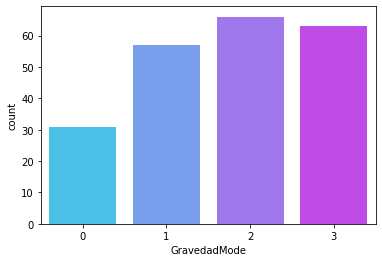

In [5]:
# Number of observations in each category for 'Modo de Gavedad'
sns.countplot(x='GravedadMode', data=data, palette='cool')
data['GravedadMode'].value_counts()

In [6]:
#Number of special characters for each instance 

df['money'] = df['Item (Texto)'].str.count('\\$')
df['percentages'] = df['Item (Texto)'].str.count('\\%')
df['digits'] = df['Item (Texto)'].str.count('\\d')
df['quotes'] = df['Item (Texto)'].str.count('\\"')
df['dashes'] = df['Item (Texto)'].str.count('\\-')
df['parentheses'] = df['Item (Texto)'].str.count('\\(')
df.head()

,Item (Texto),Gravedad,Sesgo,Nombre del Equipo,GravedadMode,SesgoMode,money,percentages,digits,quotes,dashes,parentheses
0,"Las protestas, sin precedentes, ya completan c...","2,2,2,2,3,2,2,2","1,-1,1,1,-1,1,0,0",Sample,2,1,0,0,0,0,0,0
1,"Antes rivales irreconciliables en las canchas,...","1,1,2,0,0,2,1,1,1,0","1,0,0,1,0,0,0,0,0",Sample,1,0,0,0,4,0,0,0
2,Una patrullera de la Policía Nacional denunció...,"3,3,3,3,3,3,3,3,3","1,1,1,1,1,1,1,1,1",Sample,3,1,0,0,2,0,0,0
3,"A simple vista, todo lo que ha dicho Petro es ...","1,0,0,1,1,0,1,1","-1,0,1,1,1,1,1,1",Sample,1,1,0,0,0,0,0,0
4,Durante los últimos 26 días desde que se convo...,"3,3,3,3,3,3,3,3,3","0,-1,0,0,0,0,0,0,0",Sample,3,0,0,0,13,0,0,4


In [7]:
def plot_special_chars(mode):
    
    '''Plot the number of special characters for each category'''
    
    fig = plt.subplots(figsize=(18, 10))

    columns = ['digits','quotes', 'parentheses',  'percentages', 'dashes', 'money']

    #  Categorical Data
    a = 2  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    for i in columns:
        plt.subplot(a, b, c)
        plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
        plt.xlabel(i)
        plt.ylabel('Counts')
        sns.barplot(x=df[mode].groupby(df[i] != 0).value_counts()[1].index, y=df[mode].groupby(df[i] != 0).value_counts()[1], palette='cool')
        c = c + 1

    plt.show()

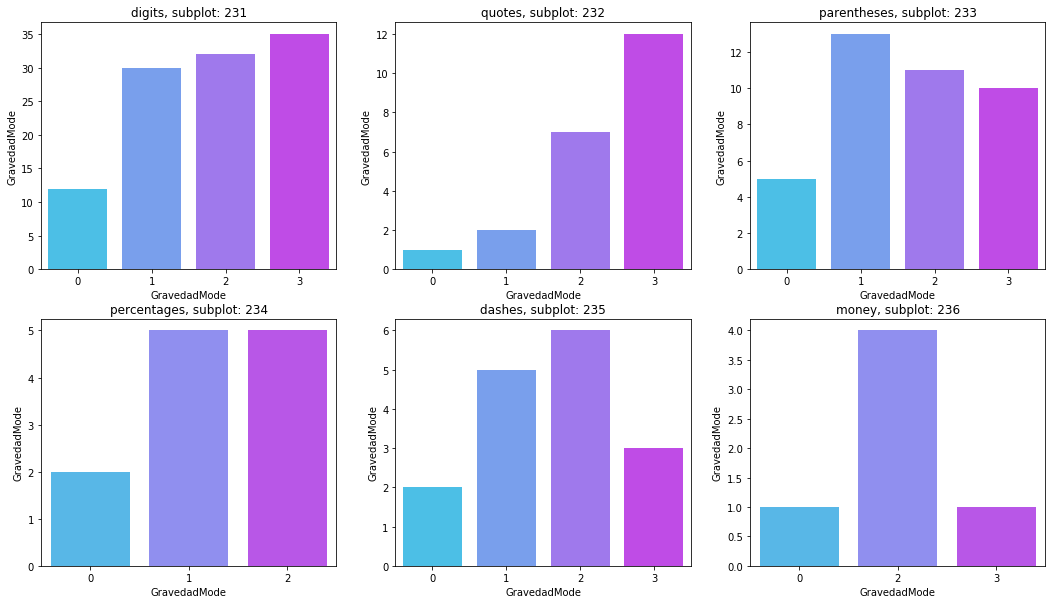

In [8]:
plot_special_chars('GravedadMode')

---
## Preprocess Text

## Stemmer

Stemming reduces the words to a common base form.

In [9]:
import stanza
stanza.download("es")

2021-07-30 19:01:50 INFO: Downloading default packages for language: es (Spanish)...
2021-07-30 19:02:01 INFO: File exists: /Users/daniandreacosmo/stanza_resources/es/default.zip.
2021-07-30 19:02:20 INFO: Finished downloading models and saved to /Users/daniandreacosmo/stanza_resources.


In [10]:
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

2021-07-30 19:02:20 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-07-30 19:02:20 INFO: Use device: cpu
2021-07-30 19:02:20 INFO: Loading: tokenize
2021-07-30 19:02:20 INFO: Loading: mwt
2021-07-30 19:02:20 INFO: Loading: pos
2021-07-30 19:02:27 INFO: Loading: lemma
2021-07-30 19:02:29 INFO: Done loading processors!


## StopWords

Remove the most common words from the spanish language. Which are the following:

In [11]:
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [12]:
nltk.download('stopwords')
sw_nltk = stopwords.words('spanish')

#The word "no" can change the meaning of a sentence. It will probably be important for the n-grams
sw_nltk.remove('no')

# Due to the context of this dataset, these words are also irrelevant: 
sw_nltk.extend(['paro', 'nacional', 'país', 'protesta']) 
print(sw_nltk)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniandreacosmo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    nopunc = re.sub('[^a-zA-ZáéíóúüÁÉÍÓÚÜñÑ$"%]', ' ', sen)

    #Remove Stop Words
    removestop = [word for word in nopunc.split() if word.lower() not in sw_nltk]
    joinRemovestop = " ".join(removestop)

    #Stemmer
    stemmer = nlp(joinRemovestop)
    joinStemmer = " ".join([f'{word.lemma}' for sent in stemmer.sentences for word in sent.words])

    return joinStemmer

## Words in each category

A Word Cloud can be created to display the most common words in the preprocessed texts for each category.

In [14]:
# Add a column with preprocess text

data['process_text'] = data['Item (Texto)'].map(preprocess_text)
data.head()

/Users/daniandreacosmo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Item (Texto),GravedadMode,SesgoMode,process_text
0,"Las protestas, sin precedentes, ya completan c...",2,1,protesta precedente completar casi mes salir c...
1,"Antes rivales irreconciliables en las canchas,...",1,0,rival irreconciliable cancha hoy compañero soc...
2,Una patrullera de la Policía Nacional denunció...,3,1,patrullera Policía denunciar jueves violado vá...
3,"A simple vista, todo lo que ha dicho Petro es ...",1,1,simple vista dicho Petro claramente exageració...
4,Durante los últimos 26 días desde que se convo...,3,0,último día convocar negativo directriz Gobiern...


In [15]:
def categoryWordcloud(names, mode):
    
    '''Plot a Word Cloud for each category'''
    
    # Categories according to mode
    words = ['words_'+str(i) for i in range(len(names))]
    
    # Extract the words for each category
    for j in range(len(names)):
        #words[j] = [i for i in data[data[mode]==str(j)]['process_text']]
        words[j] = [i for i in data['process_text'].loc[data[mode]==str(j)] ]
      
    # Create the Word Clouds
    plt.figure(figsize = (22,8))

    for i in range(len(names)):
    
        wordcloud = WordCloud(width=1024,height=1024,background_color="white").generate(" ".join(words[i]))
    
        plt.subplot(2, 2, i+1)
        plt.title('{}, subplot: {}{}{}'.format(names[i], 2,2,i+1))
        plt.imshow(wordcloud)
        plt.axis('off')


    plt.tight_layout()
    

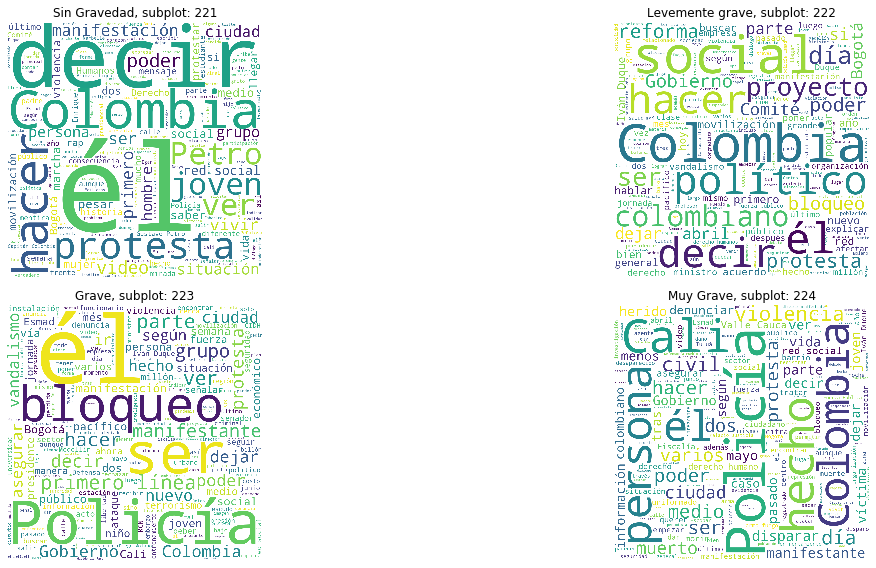

In [16]:
categoryWordcloud(names = ['Sin Gravedad','Levemente grave', 'Grave', 'Muy Grave'], mode = 'GravedadMode')

## Train and Test sets

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Split the data into Train and Test sets

X_train_grav, X_test_grav, y_train_grav, y_test_grav = train_test_split(data['process_text'], data['GravedadMode'], test_size = 0.2, random_state = 0)
print('X_train_grav size:', X_train_grav.shape)
print('y_train_grav size:', y_train_grav.shape)
print('X_test_grav size:', X_test_grav.shape)
print('y_test_grav size:', y_test_grav.shape)
X_train_grav.head()

X_train_grav size: (173,)
y_train_grav size: (173,)
X_test_grav size: (44,)
y_test_grav size: (44,)


189    Gustavo Petro instigar no rechazar violencia E...
146    cumplir dos mes inicio Colombia Bogotá vivir h...
130    objetivo organización social indígena campesin...
22     varios organización nacional internacional ale...
181    empatía víctima asesinato joven Santiago Muril...
Name: process_text, dtype: object

In [19]:
# An instance before being pre-processed
data['Item (Texto)'].iloc[2]

'Una patrullera de la Policía Nacional denunció este jueves que fue violada por vándalos en Cali, Valle del Cauca. La oficial se encontraba en labores de seguridad durante las manifestaciones del pasado 29 de abril cuando ocurrieron los hechos. Había sido asignada para brindar seguridad en un sector al oriente de Cali. En medio de los actos vandálicos, ella ingresó al CAI para protegerse. Pero los vándalos la emprendieron contra las instalaciones y lo prendieron fuego. Allí, esta mujer empezó a vivir los momentos más duros de su vida.'

In [20]:
# The same instance now preprocessed 
X_train_grav[2]

'patrullera Policía denunciar jueves violado vándalo Cali Valle Cauca oficial encontrar labor seguridad manifestación pasado abril ocurrir hecho ser asignar brindar seguridad sector oriente Cali medio acto vandá¡lico ingresar CAI proteger él vanda él emprender instalación prender fuego allí mujer empezar vivir momento duro vida'

## Vectorization

`CountVectorize` Converts the document collection to a series of token counts. 
A sparse matrix is created: 
- Each row is a document 
- Each column is a word from the vocabulary word. 
- The Entries are the number of times the word appears in each document.
- Trigrams and bigrams are used.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
vect = CountVectorizer(min_df=2, ngram_range = (1,3), lowercase = False, token_pattern = '"|[a-zA-ZáéíóúüÁÉÍÓÚÜñÑ$%-]+').fit(X_train_grav)
X_train_vect_grav = vect.transform(X_train_grav)
X_test_vect_grav = vect.transform(X_test_grav)
feature_names = np.array(vect.get_feature_names())
feature_names[::50]

array(['"', 'Central Unitaria', 'Federación', 'Margarita',
       'República Iván Duque', 'acto vandá', 'antigubernamental',
       'barricada', 'casco', 'completar', 'crear', 'dejar daño', 'dicho',
       'electoral', 'estrato', 'formar parte', 'haber', 'incinerar',
       'jornada manifestación', 'luz', 'menor', 'mujer expresar',
       'ocurrir', 'paso', 'policía', 'principal', 'realizar', 'respuesta',
       'si bien', 'terminar', 'uribismo', 'viral'], dtype='<U34')

## TF-IDF (Term Frequency times inverse document frequency): 

It allows to reduce the weightage of the most common words which occurs in all document. That is, the more common across documents, the lower its score, and the more unique a word is, the higher the score.

**TF:** Term Frequency, which measures how frequently a term occurs in a document. 

    TF(t) =  Number of times term t appears in a document / Total number of terms in the document

**IDF:** Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones:

    IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer

In [24]:
tfid = TfidfTransformer(use_idf = True)
X_train_tfidf_grav = tfid.fit_transform(X_train_vect_grav)
X_test_tfidf_grav = tfid.fit_transform(X_test_vect_grav)
print(f"Shape train set: {X_train_tfidf_grav.shape}. Shape test set: {X_test_tfidf_grav.shape}")

Shape train set: (173, 1578). Shape test set: (44, 1578)


In [25]:
# print idf values 
df_idf = pd.DataFrame(tfid.idf_, index=vect.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'], ascending=False)

,idf_weights
gobierno hacer,4.806662
interrupción,4.806662
lejos,4.806662
leer,4.806662
lamentar,4.806662
...,...
él,2.504077
dejar,2.408767
social,2.321756
Colombia,2.241713


## Selector K

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

In this method, we calculate the chi-square metric between the target and the numerical variable and only select the desired number of variable with the best chi-squared values.

In [26]:
from sklearn.feature_selection import SelectKBest

In [27]:
selector = SelectKBest(score_func=chi2, k=1000)
selector.fit(X_train_tfidf_grav, y_train_grav)

X_train_features_grav = selector.transform(X_train_tfidf_grav)
X_test_features_grav = selector.transform(X_test_tfidf_grav)

X_train_features_grav.shape, X_test_features_grav.shape

((173, 1000), (44, 1000))

## Data reduction for visualization

In [28]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def data_reduction(X_train, y_train):
    reduced_data = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    reduced_data = reduced_data.fit_transform(X_train)

    colors = ['magenta','blue','turquoise','orange']
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for i in range(y_train.shape[0]):
        ax.scatter(reduced_data[i, 0], reduced_data[i, 1], c=colors[int(y_train.reset_index(drop=True)[i])], alpha=0.6)


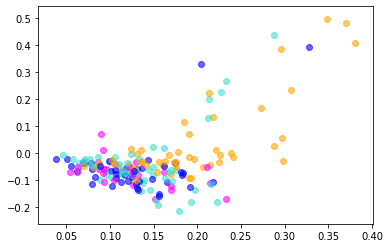

In [29]:
data_reduction(X_train_features_grav, y_train_grav)

## Model

### Logistic Regression

- **Regularization** 
Through a constant, it reduces the weight of some of the terms of the function by increasing its cost.
    - Leads to small values for the parameters.
    - Leads to a simpler hypothesis (if it is very large, it can cause a misfit by simplifying the cost function)


- **C**: Is the inverse of regularization strength. Smaller values specify stronger regularization.

In [30]:
#model
logistic_model = LogisticRegression(C=10, solver='lbfgs', max_iter=100).fit(X_train_features_grav, y_train_grav)

#predict
y_pred_grav = logistic_model.predict(X_test_features_grav)

# Sort the coefficients from the model
sorted_coef_index = logistic_model.coef_[0].argsort()
print('Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))

Coefs:
['"' 'disidencia Farc' 'Diego Molano' 'día no'
 'fusil disparar manifestante' 'Humanos' 'barrio popular' 'empresarial'
 'Dios' 'mayoría' 'derecho humanos' 'brutalidad' 'civil disparar'
 'manifestación' 'hombre' 'gas lacrimógeno' 'estructura' 'entidad' 'mejor'
 'gritar']



## Metrics

- **Precision:** Measures how many of the samples predicted as positive are actually positive.
   - It is the probability that a randomly retrieved data is relevant.
   - To limit the number of false positives.
   - If the precision value is equal to one, it will be understood that all the retrieved documents are relevant.

    $$\text{Precisión} = \frac{TP}{TP + FP}$$

- **Recall:** It is the proportion of relevant data retrieved, compared to the total of the data that are relevant existing in the database.
   - Allows you to limit false negatives.
   - If the result is 1, it indicates that all relevant documents that resided in the database have been found.

     $$\text{Exhaustividad} = \frac{TP}{TP + FN}$$

- **f-Score** Is the harmonic mean between precision and Recall.

$$f = 2  \frac{\text{Precisión}*\text{Exhaustividad}}{\text{Precisión}+\text{Exhaustividad}}$$

- The Macro F1-score is defined as the mean of class-wise/label-wise F1-scores.

In [31]:
def heatmap_confusion_matrix(y_test, y_pred, labels):
    
    '''Creates the confusion matrix and the classification report'''
    
    confusion = confusion_matrix(y_test, y_pred)
 
    sns.heatmap(confusion.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues",
            xticklabels=labels, yticklabels=labels)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    print(classification_report(y_test, y_pred, target_names=labels))
    
    return confusion

In [32]:
# Misclassification

def misclassified(confusion):
    return np.triu(confusion).sum()-np.trace(confusion) + np.tril(confusion).sum()-np.trace(confusion)

              precision    recall  f1-score   support

     NoGrave       1.00      0.20      0.33         5
        Leve       0.75      0.64      0.69        14
       Grave       0.50      0.77      0.61        13
    MuyGrave       0.73      0.67      0.70        12

    accuracy                           0.64        44
   macro avg       0.74      0.57      0.58        44
weighted avg       0.70      0.64      0.63        44

Number of observations misclassified: 16


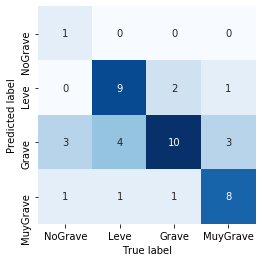

In [33]:
# Metrics: Confusion Matrix 
confusion_grav = heatmap_confusion_matrix(y_test_grav, y_pred_grav, ['NoGrave', 'Leve', 'Grave', 'MuyGrave'])
print('Number of observations misclassified:', misclassified(confusion_grav))

## Doc2Vec

Now instead of TF-IDF I use Doc2Vec. This is a model that represents each document as a vector and relates to the relationship between the words, rather than their presence or not in an instance.

In [34]:
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn import utils
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

/Users/daniandreacosmo/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [35]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each text to have a label associated with it.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled


In [36]:
X_train_d2v_grav = label_sentences(X_train_grav, 'Train')
X_test_d2v_grav = label_sentences(X_test_grav, 'Test')
X_train_d2v_grav[1]

TaggedDocument(words=['cumplir', 'dos', 'mes', 'inicio', 'Colombia', 'Bogotá', 'vivir', 'hecho', 'violencia', 'vandalismo', 'dejar', 'daño', 'sistema', 'transporte', 'público', 'ciudad', 'persona', 'lesionado', 'capturado'], tags=['Train_1'])

### **Distributed Bag of Words (DBOW)**

The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

- vector_size: Dimensionality of the feature vectors.
- min_count: Ignores all words with total frequency lower than this.
- negative: If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
- dm: Defines the training algorithm. If dm=1, ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.
- alpha: The initial learning rate.
- min_alpha: Learning rate will linearly drop to min_alpha as training progresses.

In [37]:
# Corpus
all_data_grav = X_train_d2v_grav + X_test_d2v_grav

# Model Doc2Vec 
model_dbow_grav = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow_grav.build_vocab([x for x in tqdm(all_data_grav)])

100%|██████████| 217/217 [00:00<00:00, 207232.23it/s]


### Training 

Training by changing the 'alpha' learning rate. `alpha` is the initial learning rate, it will drop linearly to min_alpha as training progresses`

In [38]:
for epoch in range(30):
    model_dbow_grav.train(utils.shuffle([x for x in tqdm(all_data_grav)]), 
                          total_examples = model_dbow_grav.corpus_count, 
                          epochs = model_dbow_grav.epochs)
    
    model_dbow_grav.alpha -= 0.002
    model_dbow_grav.min_alpha = model_dbow_grav.alpha

100%|██████████| 217/217 [00:00<00:00, 329292.32it/s]


In [39]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [40]:
train_vectors_dbow_grav = get_vectors(model_dbow_grav, len(X_train_grav), 300, 'Train')
test_vectors_dbow_grav = get_vectors(model_dbow_grav, len(X_test_grav), 300, 'Test')
print(f'Shape of data {len(train_vectors_dbow_grav), len(train_vectors_dbow_grav[0])}')

Shape of data (173, 300)


In [41]:
# What words are most similar in context to the word 'autodefensa'?
model_dbow_grav.wv.most_similar('autodefensa')

[('votar', 0.19840285181999207),
 ('noche', 0.1915450394153595),
 ('criterio', 0.16239699721336365),
 ('Internacional', 0.16174620389938354),
 ('habitado', 0.16030284762382507),
 ('Comité', 0.159976989030838),
 ('Tibú', 0.15768909454345703),
 ('referir', 0.15750131011009216),
 ('Sarmiento', 0.15267230570316315),
 ('supermercado', 0.1510496735572815)]

              precision    recall  f1-score   support

     NoGrave       0.33      0.40      0.36         5
        Leve       0.55      0.43      0.48        14
       Grave       0.48      0.77      0.59        13
    MuyGrave       0.67      0.33      0.44        12

    accuracy                           0.50        44
   macro avg       0.51      0.48      0.47        44
weighted avg       0.53      0.50      0.49        44

Number of observations misclassified: 22


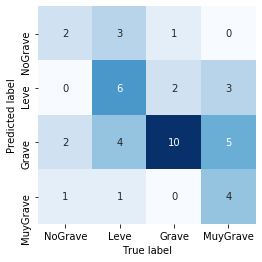

In [42]:
#model
logistic_model = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs', max_iter=800).fit(train_vectors_dbow_grav, y_train_grav)

#predict
y_pred_grav = logistic_model.predict(test_vectors_dbow_grav)

# Metrics
confusion_grav = heatmap_confusion_matrix(y_test_grav, y_pred_grav, ['NoGrave', 'Leve', 'Grave', 'MuyGrave'])
print('Number of observations misclassified:', misclassified(confusion_grav))

## Distributed Memory

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.


In [43]:
def doc2vec_training(model, all_data, vector_size, X_train, X_test, y_train, epochs_):

    for epoch in range(epochs_):
        
        model.train(utils.shuffle([x for x in tqdm(all_data)]), 
                            total_examples = model.corpus_count, 
                            epochs = model.epochs)
        model.alpha -= 0.002
        model.min_alpha = model.alpha
    
    train_vectors = get_vectors(model, len(X_train), vector_size, 'Train')
    test_vectors = get_vectors(model, len(X_test), vector_size, 'Test')
    
    return train_vectors, test_vectors

In [44]:
# Model

model_dm_grav = Doc2Vec(dm=1, dm_mean=1, window=10, negative=5, workers=5, vector_size=300, min_count=1, alpha=0.065, min_alpha=0.065)
model_dm_grav.build_vocab(all_data_grav)

In [45]:
# Train

train_vectors_dm_grav, test_vectors_dm_grav = doc2vec_training(model=model_dm_grav, 
                                                               all_data=all_data_grav, 
                                                               vector_size=300, 
                                                               X_train = X_train_grav, 
                                                               X_test = X_test_grav, 
                                                               y_train = y_train_grav, 
                                                               epochs_=30)

100%|██████████| 217/217 [00:00<00:00, 543706.07it/s]


In [46]:
# What words are most similar in context to the word 'vándalo'?
model_dm_grav.wv.most_similar('vándalo')

[('agresor', 0.7312072515487671),
 ('victimizan', 0.6707556247711182),
 ('violado', 0.6438360810279846),
 ('artefacto', 0.5737842321395874),
 ('quemado', 0.5625596046447754),
 ('patrullera', 0.5591862201690674),
 ('verificado', 0.5537601709365845),
 ('violentamente', 0.5537030100822449),
 ('Aponte', 0.5346917510032654),
 ('explosivo', 0.5194834470748901)]

              precision    recall  f1-score   support

     NoGrave       0.33      0.40      0.36         5
        Leve       0.64      0.50      0.56        14
       Grave       0.44      0.54      0.48        13
    MuyGrave       0.45      0.42      0.43        12

    accuracy                           0.48        44
   macro avg       0.47      0.46      0.46        44
weighted avg       0.49      0.48      0.48        44

Number of observations misclassified: 23


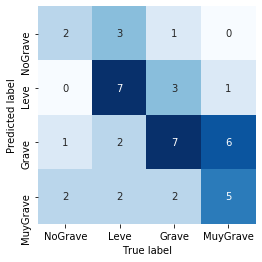

In [47]:
# Logistic regression model
logistic_model = LogisticRegression(C=100, multi_class='multinomial', solver='lbfgs', max_iter=800).fit(train_vectors_dm_grav, y_train_grav)

#predict
y_pred_grav = logistic_model.predict(test_vectors_dm_grav)

# Metrics
confusion_grav = heatmap_confusion_matrix(y_test_grav, y_pred_grav, ['NoGrave', 'Leve', 'Grave', 'MuyGrave'])
print('Number of observations misclassified:', misclassified(confusion_grav))

## Conclusion
The TF-IDF approach works best for 'Modo de Gravedad'. In this case, the words present in the documents define the seriousness of the news. Apparently it has a limit with an accuracy of 0.64. However, distributed memory performs better than distributed word bag when working with vectors.

----

# MACHINE LEARNING MODEL
## *Sesgo de la Noticia*

## Análisis Exploratorio

0    111
1     61
2     45
Name: SesgoMode, dtype: int64

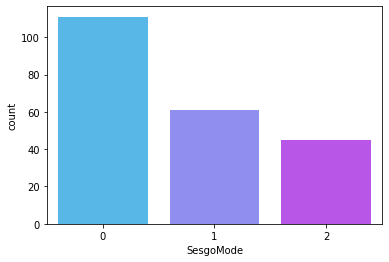

In [48]:
# Number of observations in each category for 'Modo de Sesgo'
sns.countplot(x='SesgoMode', data=data, palette='cool')
data['SesgoMode'].value_counts()

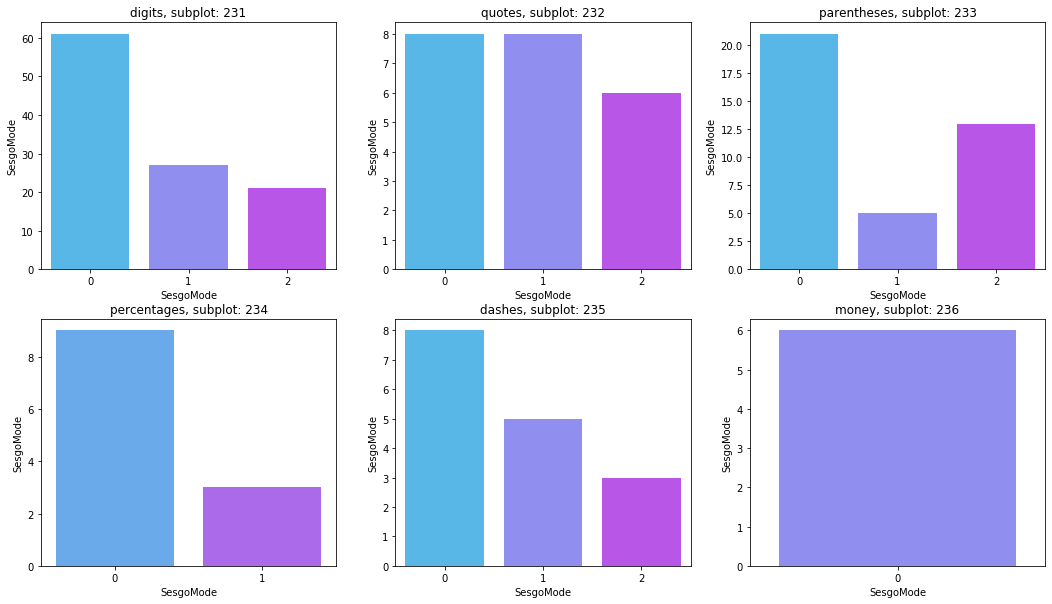

In [49]:
# Special Characters
plot_special_chars('SesgoMode')

In [50]:
# Number of observations of Sesgo Mode in each Gravedad Mode set: They are apparently not correlated
data['SesgoMode'].groupby(data['GravedadMode']).value_counts()

GravedadMode  SesgoMode
0             0            23
              1             4
              2             4
1             0            28
              1            21
              2             8
2             0            29
              1            25
              2            12
3             0            31
              2            21
              1            11
Name: SesgoMode, dtype: int64

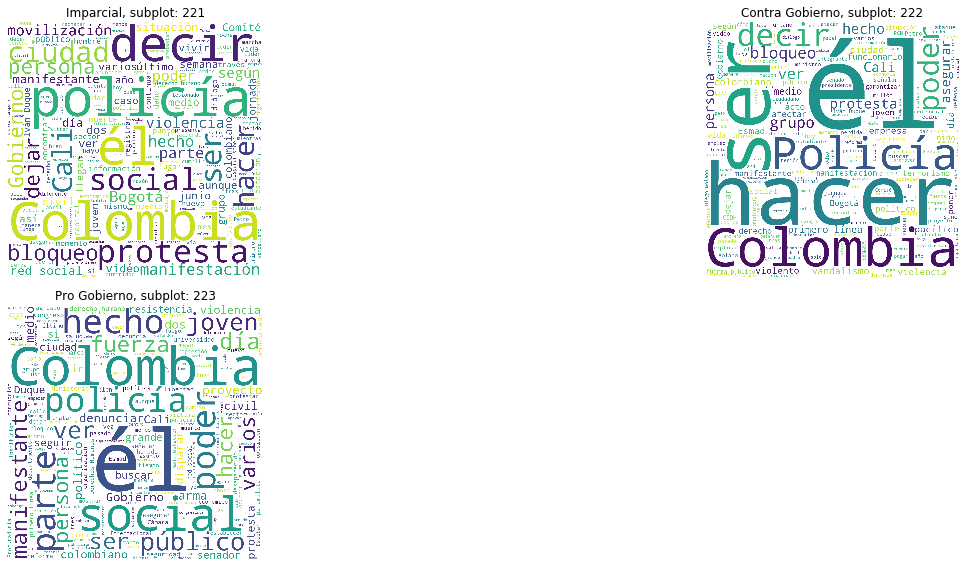

In [51]:
# Wordcloud
categoryWordcloud(['Imparcial','Contra Gobierno', 'Pro Gobierno'], mode = 'SesgoMode')

## Train and Test sets

In [52]:
X_train_sesgo, X_test_sesgo, y_train_sesgo, y_test_sesgo = train_test_split(data['process_text'], data['SesgoMode'], test_size = 0.2, random_state = 1)
print('X_train_sesgo size:', X_train_sesgo.shape)
print('y_train_sesgo size:', y_train_sesgo.shape)
print('X_test_sesgo size:', X_test_sesgo.shape)
print('y_test_sesgo size:', y_test_sesgo.shape)
X_train_sesgo.head()

X_train_sesgo size: (173,)
y_train_sesgo size: (173,)
X_test_sesgo size: (44,)
y_test_sesgo size: (44,)


117    lograr arrojar luz fractura social vivir perso...
47     Andres Escobar ver portar arma fuego disparar ...
27     panadería reposterío Antioquia escasez insumo ...
59     último hora varios congresista oposición denun...
40     bloqueo dejar pérdida orden mil millón peso co...
Name: process_text, dtype: object

## Data reduction for visualization

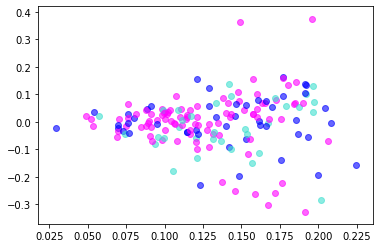

In [53]:
vect = CountVectorizer(min_df=1, ngram_range = (1,2), lowercase = True, token_pattern = '[a-zA-ZáéíóúüÁÉÍÓÚÜñÑ$%]+').fit(X_train_sesgo)
X_train_vect_sesgo = vect.transform(X_train_sesgo)
tfid = TfidfTransformer(use_idf = True)
X_train_tfidf_sesgo = tfid.fit_transform(X_train_vect_sesgo)

data_reduction(X_train_tfidf_sesgo, y_train_sesgo)

## Logistic Regression Model

              precision    recall  f1-score   support

   Imparcial       0.63      0.67      0.65        18
   ContraGob       0.47      0.57      0.52        14
      ProGob       0.75      0.50      0.60        12

    accuracy                           0.59        44
   macro avg       0.62      0.58      0.59        44
weighted avg       0.61      0.59      0.59        44

Number of observations misclassified: 18


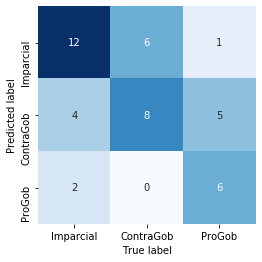

In [54]:
pipeline_sesgo = Pipeline([('vect', CountVectorizer(min_df=1, lowercase=True,  ngram_range=(1,2), token_pattern = '[a-zA-ZáéíóúüÁÉÍÓÚÜñÑ$%]+')),
                         ('tfidf', TfidfTransformer(use_idf=True)),
                         ('selector', SelectKBest(k=500, score_func=chi2)),
                         ('logic', LogisticRegression(max_iter=200, C=1000))])

pipeline_sesgo = pipeline_sesgo.fit(X_train_sesgo, y_train_sesgo)
y_pred_sesgo = pipeline_sesgo.predict(X_test_sesgo)

confusion_sesgo = heatmap_confusion_matrix(y_test_sesgo, y_pred_sesgo, ["Imparcial", "ContraGob", "ProGob"])

print('Number of observations misclassified:', misclassified(confusion_sesgo))

In [55]:
scores = cross_val_score(pipeline_sesgo, X_train_sesgo, y_train_sesgo, cv=10)
print('Cross-Validation Accuracy Scores', scores)
scores = pd.Series(scores)
scores.min(), scores.max(), scores.mean()

Cross-Validation Accuracy Scores [0.66666667 0.61111111 0.66666667 0.58823529 0.58823529 0.58823529
 0.47058824 0.58823529 0.58823529 0.29411765]


(0.29411764705882354, 0.6666666666666666, 0.5650326797385621)

## Doc2Vec for Sesgo Mode

### Distributed Memory


Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

In [56]:
def doc2vec_training(model, all_data, vector_size, X_train, X_test, y_train, epochs_):

    for epoch in range(epochs_):
        
        model.train(utils.shuffle([x for x in tqdm(all_data)]), 
                            total_examples = model.corpus_count, 
                            epochs = model.epochs)
        model.alpha -= 0.002
        model.min_alpha = model.alpha
    
    train_vectors = get_vectors(model, len(X_train), vector_size, 'Train')
    test_vectors = get_vectors(model, len(X_test), vector_size, 'Test')
    
    return train_vectors, test_vectors

In [57]:
# TaggedDocument
X_train_d2v_sesgo = label_sentences(X_train_sesgo, 'Train')
X_test_d2v_sesgo = label_sentences(X_test_sesgo, 'Test')
X_train_d2v_sesgo[1]

TaggedDocument(words=['Andres', 'Escobar', 'ver', 'portar', 'arma', 'fuego', 'disparar', 'manifestante', 'Cali', 'menos', 'persona', 'morir', 'día', 'disparo', 'Escobar', 'supuesto', 'empresario', 'junto', 'agente', 'policía', 'presumir', 'complicidad', 'ambos', 'parte', 'Fiscalía', 'Colombia', 'no', 'pronunciado', 'hecho', 'embargo', 'ciudadano', 'poder', 'pagar', 'varios', 'año', 'cárcel', 'haber', 'cometer', 'varios', 'delito', 'posiblemente', 'colombiano', 'bien', 'relación', 'grupo', 'narcoparamilitar', 'Cali'], tags=['Train_1'])

In [58]:
# Corpus
all_data_sesgo = X_train_d2v_sesgo + X_test_d2v_sesgo

# Model
model_dm_sesgo = Doc2Vec(dm=1, vector_size=1000, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dm_sesgo.build_vocab([x for x in tqdm(all_data_sesgo)])

100%|██████████| 217/217 [00:00<00:00, 106265.50it/s]


In [59]:
# Train
train_vectors_dm_sesgo, test_vectors_dm_sesgo = doc2vec_training(model=model_dm_sesgo, 
                                                                 all_data=all_data_sesgo, 
                                                                 vector_size=1000, 
                                                                 X_train = X_train_sesgo, 
                                                                 X_test = X_test_sesgo, 
                                                                 y_train = y_train_sesgo, 
                                                                 epochs_=30)

100%|██████████| 217/217 [00:00<00:00, 684333.81it/s]


In [60]:
# What words are most similar in context to the word 'vándalo'?
model_dm_sesgo.wv.most_similar('vándalo')

[('violentamente', 0.7627016305923462),
 ('verificado', 0.7059823274612427),
 ('atacado', 0.6955959796905518),
 ('violado', 0.6829007267951965),
 ('agresor', 0.6575308442115784),
 ('Atención', 0.6188616156578064),
 ('victimizan', 0.5949995517730713),
 ('artefacto', 0.5666170716285706),
 ('despiadado', 0.5638890266418457),
 ('jueves', 0.5544151663780212)]

              precision    recall  f1-score   support

   Imparcial       0.44      0.61      0.51        18
   ContraGob       0.23      0.21      0.22        14
      ProGob       0.50      0.25      0.33        12

    accuracy                           0.39        44
   macro avg       0.39      0.36      0.36        44
weighted avg       0.39      0.39      0.37        44

Number of observations misclassified: 27


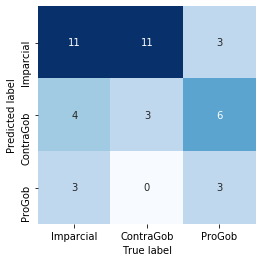

In [61]:
# Logistic Regression Model
logistic_model = LogisticRegression(C=10,solver='lbfgs', max_iter=1000).fit(train_vectors_dm_sesgo, y_train_sesgo)

# Predic
y_pred_sesgo = logistic_model.predict(test_vectors_dm_sesgo)

# Metrics
confusion_sesgo = heatmap_confusion_matrix(y_test_sesgo, y_pred_sesgo, ["Imparcial", "ContraGob", "ProGob"])

print('Number of observations misclassified:', misclassified(confusion_sesgo))

## Conclusion

In 'Sesgo' mode, IF-IDF also performs best with 0.59 precision. However, if the Distributed Memory is applied with Doc2Vec, the model shows that it has more problems to classify the news 'Imparcial' and 'Contra Gobierno'. Probably because the news against the government were difficult to find and if an impartial news story says something that could show the bad decisions of the government, it does not mean that the news is biased.

On the other hand, bias has more to do with the structure and intent of the news. An unbiased story can contain almost the same words but in a different order or context.

Also, it is not just the news itself. A magazine can talk about vandalism in the protests in an article and be apparently impartial, but when in each of its news it only talks about the negative effects of the protests, it never does a real analysis of why people are protesting, it gives voice to the perpetrator to explain their actions but not to the victims, remains silent in the cases of murder, disappearance or rape against civilians, always tries to find an organization or public figure to blame for the protests but never the social, economic background that generated them. There is the bias. We can also find it in the omission, in the silence, in its focus and in its repetition, which in the end generates an accepted general consciousness about the situation of the country.